# Introduction to Reservoir Computing with ReservoirPy

In [22]:
from reservoirpy.nodes import Reservoir, Ridge, FORCE

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from reservoirpy import mat_gen, ESN

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Mackey-Glass timeserie

Mackey-Glass equation are a set of delayed differential equations describing the temporal behaviour of different physiological signal, for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$
\frac{dP(t)}{dt} = \frac{a P(t - \tau)}{1 + P(t - \tau)^n} - bP(t)
$$

where $a = 0.2$, $b = 0.1$, $n = 10$, and the time delay $\tau = 17$. $\tau$ controls the chaotic behaviour of the equations (the higher it is, the more chaotic the timeserie becomes. $\tau=17$ already gives good chaotic results.)

In [3]:
from reservoirpy.datasets import mackey_glass

timesteps = 25000
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [4]:
def plot_mackey_glass(X, sample, tau):

    t = np.arange(X.shape[0])

    fig = plt.figure(figsize=(13, 5))

    plt.subplot((121))
    plt.title(f"Timeserie - {sample} timesteps")
    plt.plot(t[:sample], X[:sample], lw=2,
             color="lightgrey", zorder=0)
    plt.scatter(t[:sample], X[:sample], c=t[:sample], cmap="viridis", s=6)
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax = plt.subplot((122))
    ax.margins(0.05)
    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.plot(X[0: sample], X[tau: sample+tau], lw=1,
             color="lightgrey", zorder=0)
    plt.scatter(X[:sample], X[tau: sample+tau],
             lw=0.5, c=t[:sample], cmap="viridis", s=6)
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    plt.tight_layout()
    plt.show()

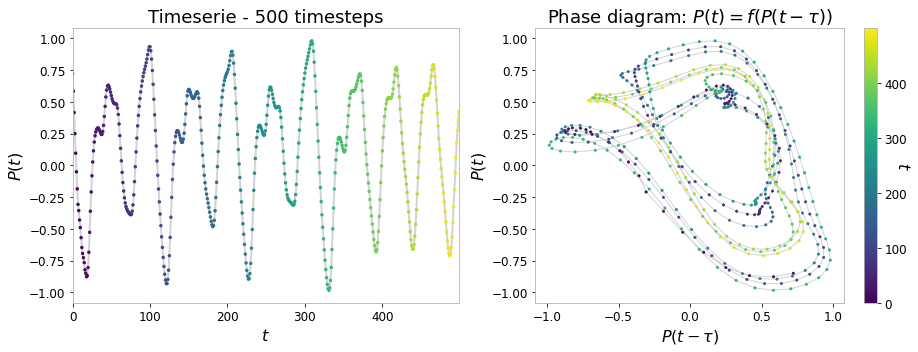

In [5]:
plot_mackey_glass(X, 500, tau)

## Prepare the tasks

- Task 1: prediction of the timeserie: from $P(t)$ predict $P(t + 1)$, $P(t + 10)$ (the forecast)

- Task 2: generation of the timeserie (from $P$ generate $\hat{P}$, and run it over several timesteps).

In [6]:
def split_timeserie_for_task1(forecast, train_length=20000):

    X_train, y_train = X[:train_length], X[forecast: train_length+forecast]
    X_test, y_test = X[train_length: -forecast], X[train_length+forecast:]

    return (X_train, y_train), (X_test, y_test)

## Task 1 : prepare data

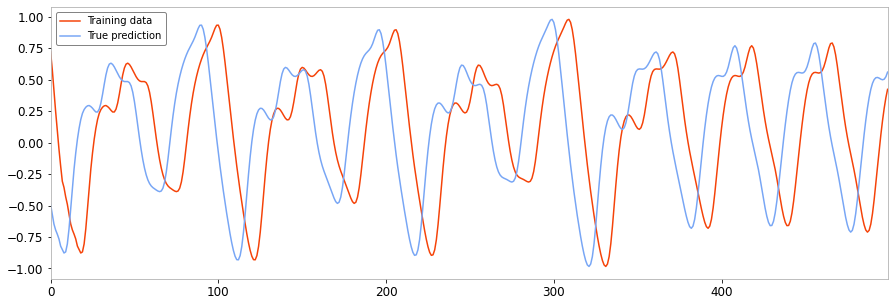

In [7]:
forecast = 10  # for now, predict 10 steps ahead
(X_train, y_train), (X_test, y_test) = split_timeserie_for_task1(forecast)

sample = 500
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(y_train[:sample], label="True prediction")
plt.legend()

plt.show()

## Task 1: prepare the ESN

In [8]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
density = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

In [9]:
def reset_esn():
    Win = mat_gen.generate_input_weights(units, 1, input_scaling=input_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

    W = mat_gen.generate_internal_weights(units, sr=spectral_radius,
                                  proba=density, seed=seed)

    reservoir = ESN(leak_rate, W, Win, ridge=regularization)

    return reservoir

In [94]:
def reset_esn():
    res = Reservoir(100, lr=leak_rate, sr=spectral_radius, input_scaling=input_scaling, rc_connectivity=density,
                    input_connectivity=input_connectivity, seed=seed)
    read = FORCE(1, batch_size=1)

    return res >> read

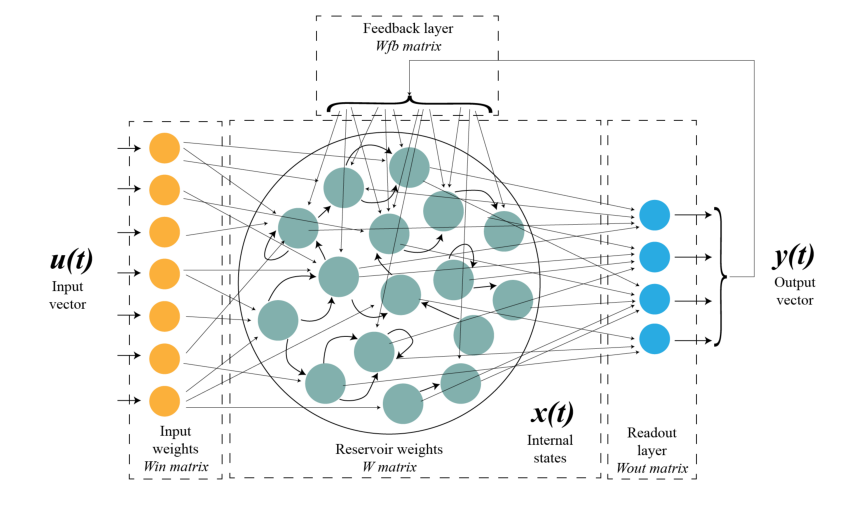

In [95]:
im = plt.imread("./static/esn.png")
plt.figure(figsize=(15, 15)); plt.imshow(im); plt.axis('off'); plt.show()

In [96]:
Win = mat_gen.generate_input_weights(units, 1, input_scaling=input_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

W = mat_gen.generate_internal_weights(units, sr=spectral_radius,
                              proba=density, seed=seed)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

IndexError: tuple index out of range

In [97]:
model = reset_esn()

## Task 1: train and test the ESN

In [98]:
y_pred = model.train(X_train, y_train)

In [99]:
y_pred = model.run(X_test)

In [91]:
states = reservoir.train([X_train.reshape(-1, 1)], [y_train.reshape(-1, 1)], return_states=True, verbose=True)

y_pred, states1 = reservoir.run([X_test.reshape(-1, 1)], init_state=states[0][-1], return_states=True, verbose=True)

y_pred = y_pred[0].reshape(-1, 1)
states1 = states1[0]

NameError: name 'reservoir' is not defined

In [100]:
def r2_score(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))

def nrmse(y_true, y_pred):
    return np.sqrt((np.sum(y_true - y_pred)**2) / len(y_true)) / (y_true.max() - y_true.min())

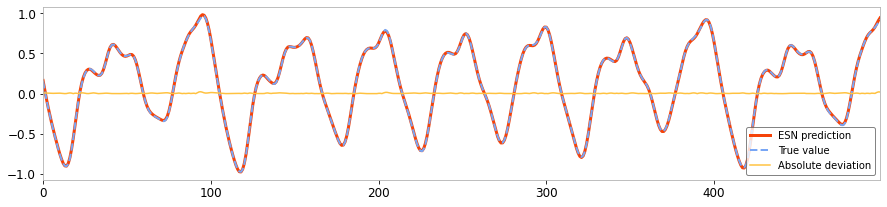

In [101]:
sample = 500

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

plt.legend()
plt.show()

Determination coefficient $R^2$ and normalized root mean square (NRMSE) :

In [19]:
r2_score(y_test, y_pred), nrmse(y_test, y_pred)

(0.9999226785588726, 0.0006859910764961856)

## Task 1 : make the task harder

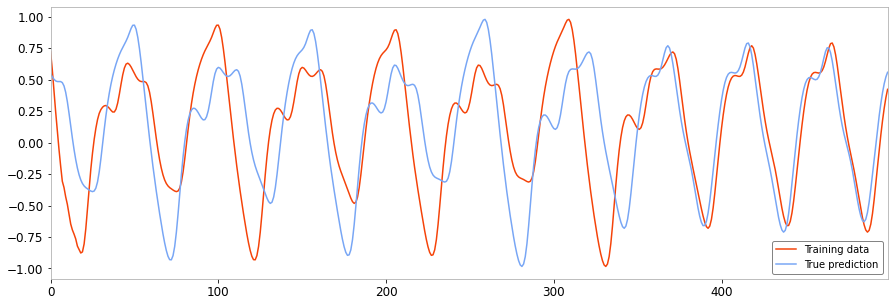

In [26]:
forecast = 50  # now, predict 50 steps ahead
(X_train, y_train), (X_test, y_test) = split_timeserie_for_task1(forecast)

sample = 500
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(y_train[:sample], label="True prediction")
plt.legend()

plt.show()

In [64]:
states = reservoir.train([X_train.reshape(-1, 1)], [y_train.reshape(-1, 1)], return_states=True, verbose=True)

y_pred, states2 = reservoir.run([X_test.reshape(-1, 1)], init_state=states[0][-1], return_states=True, verbose=True)

y_pred = y_pred[0].reshape(-1, 1)
states2 = states2[0]

Training on 1 inputs (20000 steps) -- wash: 0 steps


Train: 100%|██████████| 20000/20000 [00:03<00:00, 6457.38it/s]


Running on 1 inputs (4950 steps)


Run: 100%|██████████| 4950/4950 [00:00<00:00, 6370.34it/s]


In [27]:
y_pred = reservoir.fit(X_train, y_train).run(X_test)

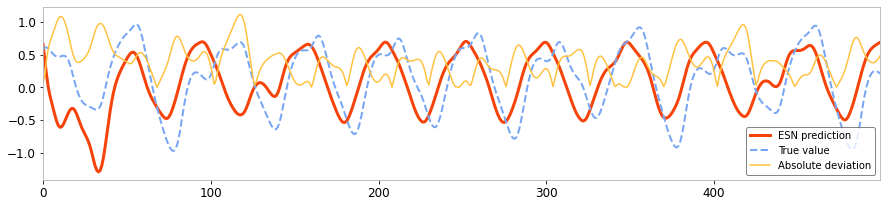

In [28]:
sample = 500

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

plt.legend()
plt.show()

Determination coefficient $R^2$ and NRMSE:

In [66]:
r2_score(y_test, y_pred), nrmse(y_test, y_pred)

(0.9986249231695803, 0.0147203299238372)

## Task 1 : diving into the reservoir

Let's have a look at the effect of some of the hyperparameters of the ESN.

### Spectral radius


The spectral radius is defined as the maximum eigenvalue of the reservoir matrix.

In [67]:
reservoir = reset_esn()

states = []
radii = [0.1, 1.25, 10.0]
for sr in radii:
    W = mat_gen.generate_internal_weights(units, sr=sr,
                                          proba=density, seed=seed)
    reservoir.W = W
    s = reservoir.compute_all_states([X_test[:500].reshape(-1, 1)])
    states.append(s[0])

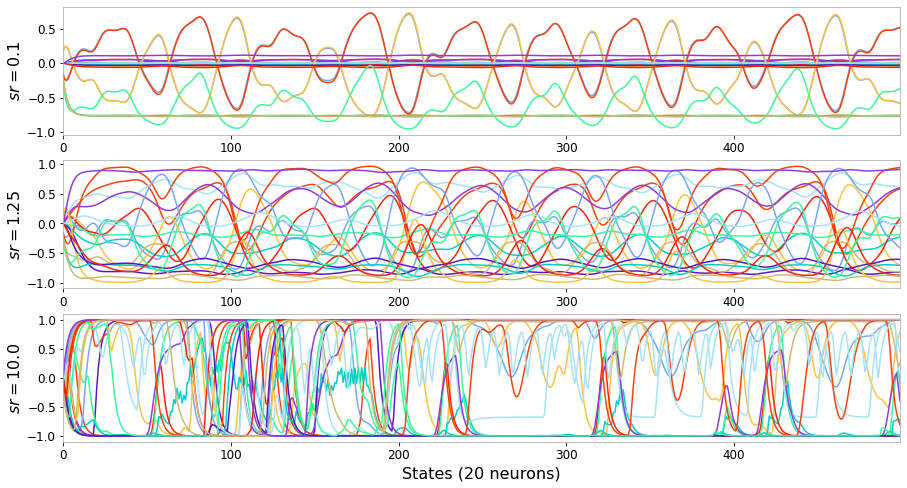

In [68]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(radii)*100+10+i+1)
    plt.plot(s[:, :units_nb])
    plt.ylabel(f"$sr={radii[i]}$")
plt.xlabel(f"States ({units_nb} neurons)")
plt.show()

- $-$ spectral radius $\rightarrow$ **stable** dynamics

- $+$ spectral radius $\rightarrow$ **chaotic** dynamics

In most cases, it should have a value around $1.0$ to ensure the *echo state property* (ESP): the dynamics of the reservoir should not be bound to the initial state chosen, and remains close to chaos.

This value also heavily depends on the input scaling.

### Input scaling

The input scaling controls how the ESN interact with the inputs. It is a coefficient appliyed to the input matrix $W_{in}$.

In [69]:
reservoir = reset_esn()

states = []
scalings = [0.1, 1.0, 10.0]
for iss in scalings:
    Win = mat_gen.generate_input_weights(units, 1, input_scaling=iss,
                                         proba=input_connectivity, input_bias=True,
                                         seed=seed)
    reservoir.Win = Win
    s = reservoir.compute_all_states([X_test[:500].reshape(-1, 1)])
    states.append(s[0])

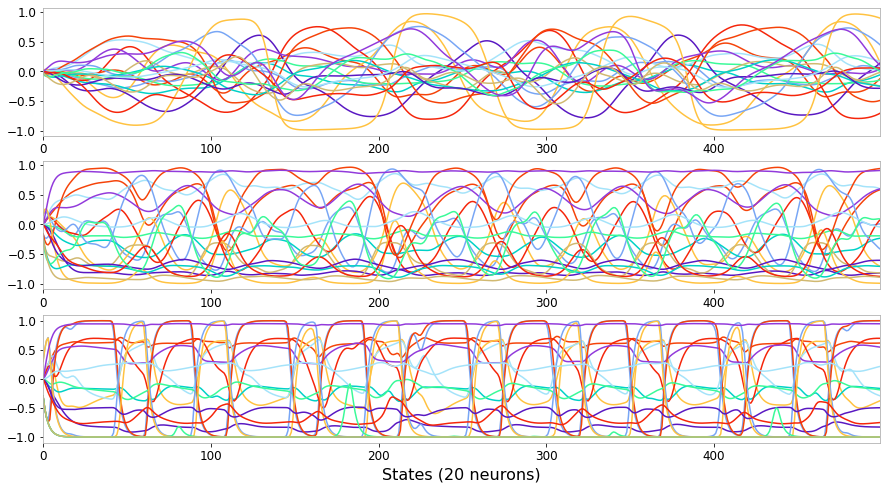

In [70]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(scalings)*100+10+i+1)
    plt.plot(s[:, :units_nb])
plt.xlabel(f"States ({units_nb} neurons)")
plt.show()

- $+$ input scaling $\rightarrow$ **input-driven** activities
- $-$ input scaling $\rightarrow$ **free** activities

The input scaling can also be used to rescale the inputs and ajust their influences.

### Leaking rate

The leaking rate ($\alpha$) controls the "memory feedback" of the ESN. The ESN states are indeed computed as:

$$
s(t+1) =  \underbrace{\color{red}{(1 - \alpha)} s(t)}_{\text{previous states}} + \underbrace{\color{red}\alpha f(u(t+1), s(t))}_{\text{new states}}
$$

where $s$ is the state, $u$ is the input data, $f$ is the ESN model function, defined as:

$$ f(u, s) = \tanh(W_{in} \cdotp u + W \cdotp s) $$

$\alpha$ must be in $[0; 1]$.

In [71]:
reservoir = reset_esn()

states = []
rates = [0.03, 0.3, 0.99]
for lr in rates:
    reservoir.lr = lr
    s = reservoir.compute_all_states([X_test[:500].reshape(-1, 1)])
    states.append(s[0])

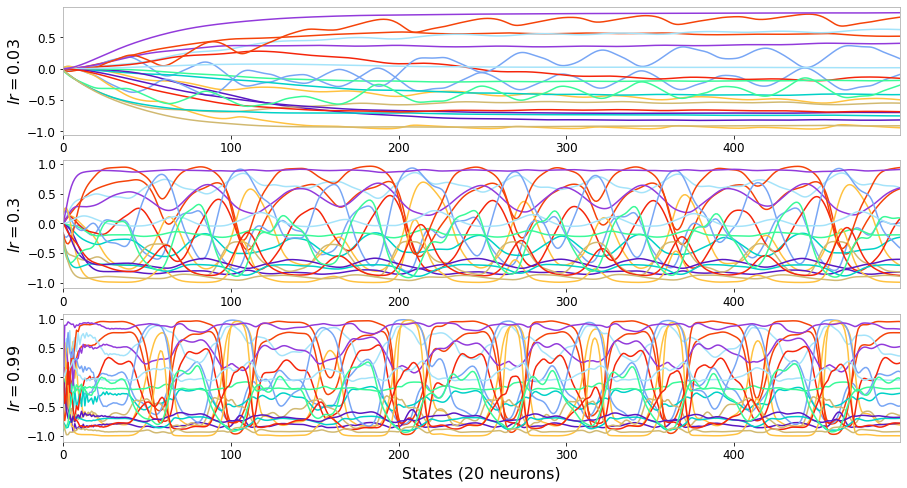

In [72]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(rates)*100+10+i+1)
    plt.plot(s[:, :units_nb])
    plt.ylabel(f"$lr={rates[i]}$")
plt.xlabel(f"States ({units_nb} neurons)")
plt.show()

In [73]:
reservoir = reset_esn()

Win = mat_gen.generate_input_weights(units, 1, input_scaling=0.1, input_bias=True)
reservoir.Win = Win

states = []
rates = [0.03, 0.3, 0.9]
for lr in rates:
    reservoir.lr = lr
    s = reservoir.compute_all_states([X_test[:500].reshape(-1, 1)])
    states.append(s[0])

Let's reduce the input influence to see what is happening inside the reservoir (input scaling set to $0.1$):

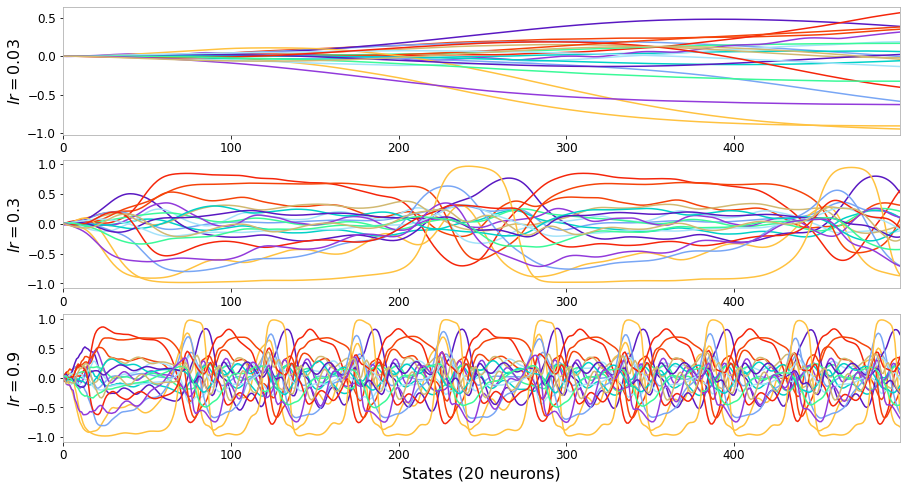

In [74]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(rates)*100+10+i+1); plt.ylabel(f"$lr={rates[i]}$")
    plt.plot(s[:, :units_nb])
plt.xlabel(f"States ({units_nb} neurons)"); plt.show()

- $+$ leaking rate $\rightarrow$ **low inertia**, little memory of previous states
- $-$ leaking rate $\rightarrow$ **high inertia**, big memory of previous states

The leaking rate can be seen as the inverse of the reservoir's time contant.

## Task 2 : generate predictions

During this task, the ESN is trained to make a short forecast of the timeserie (1 timestep ahead).
Then, it will be asked to run on its own outputs, trying to predict its own behaviour.

In [75]:
units = 500
leak_rate = 0.15
spectral_radius = 0.48
input_scaling = 1.0
density = 0.1
input_connectivity = 1.0
regularization = 1e-6
seed = 1234

reservoir = reset_esn()

forecast = 1
(X_train, y_train), (X_test, y_test) = split_timeserie_for_task1(forecast)

reservoir.train([X_train.reshape(-1, 1)], [y_train.reshape(-1, 1)], verbose=True)

Training on 1 inputs (20000 steps) -- wash: 0 steps


Train: 100%|██████████| 20000/20000 [00:04<00:00, 4392.63it/s]


In [76]:
def plot_generation(Xgen, Xgen_test, warming_inputs, warming_out, nb_generations, seed_timesteps):

    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(nb_generations)+seed_timesteps, Xgen, label="Generated timeserie")
    plt.plot(np.arange(nb_generations)+seed_timesteps, Xgen_test, linestyle="--", label="Real timeserie")

    plt.plot(np.arange(seed_timesteps), warming_out, color="lightgray", label="Warming outputs")
    plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warming inputs")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(Xgen_test - Xgen),
             label="Absolute deviation")

    plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Seed (or warming)")

    plt.plot([], [], ' ', label=f"$R^2 = {round(r2_score(Xgen_test, Xgen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(Xgen_test, Xgen), 4)}$")
    plt.legend(bbox_to_anchor=[1.005, 1], frameon=False)
    plt.show()

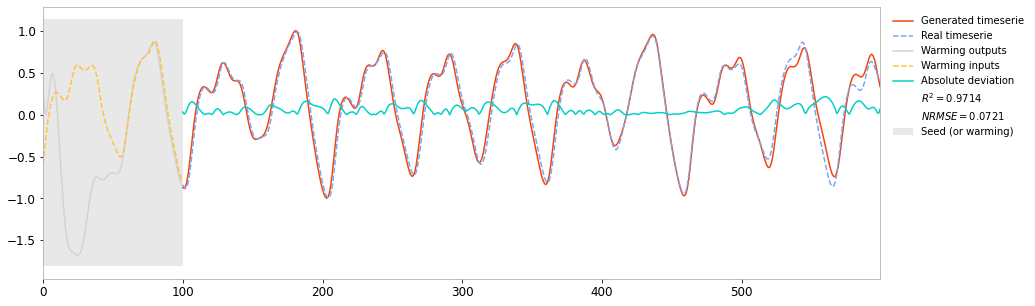

In [77]:
start = 0; seed_timesteps = 100; nb_generations = 500

warming_inputs = X_test[start:start+seed_timesteps].reshape(-1, 1)
Xgen_test = X_test[start+seed_timesteps: start+nb_generations+seed_timesteps].reshape(-1, 1)

Xgen, states, warming_out, warming_states = reservoir.generate(nb_generations,
                                                               warming_inputs=warming_inputs)
Xgen = Xgen.reshape(-1, 1); warming_out = warming_out.reshape(-1, 1)

plot_generation(Xgen, Xgen_test, warming_inputs, warming_out, nb_generations, seed_timesteps)

## Another example: generate Lorenz butterflies

Lorenz attractor is another well-known example of chaotic timeserie generator.

Here, the ESN has to predict 3 covariant values at once: the $x$, $y$ and $z$ coordinates of the Lorenz system.


We can also ask the ESN to predict one value given the two others, and so on. Of course, we can also ask for new generations of the timeserie.

In [78]:
from reservoirpy.datasets import lorenz

timesteps = 25000
X = lorenz(timesteps)

# rescale between -1 and 1
X = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1

In [79]:
def plot_lorenz(X, sample):

    t = np.arange(X.shape[0])
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    fig = plt.figure(figsize=(13, 5))

    plt.subplot((121))
    plt.title(f"Timeserie - {sample} timesteps")

    plt.plot(t[:sample], x[:sample], color="lightgray", zorder=0)
    plt.scatter(t[:sample], x[:sample], c=t[:sample], cmap="viridis", s=2, zorder=1)

    plt.xlabel("$t$")
    plt.ylabel("$x$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    ax = plt.subplot((122), projection="3d")
    ax.margins(0.05)
    plt.title(f"Phase diagram: $z = f(x, y)$")
    plt.plot(x[:sample], y[:sample], z[:sample], lw=1,
             color="lightgrey", zorder=0)
    plt.scatter(x[:sample], y[:sample], zs=z[:sample],
             lw=0.5, c=t[:sample], cmap="viridis", s=2)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.set_zlabel("$z$")

    plt.tight_layout()
    plt.show()

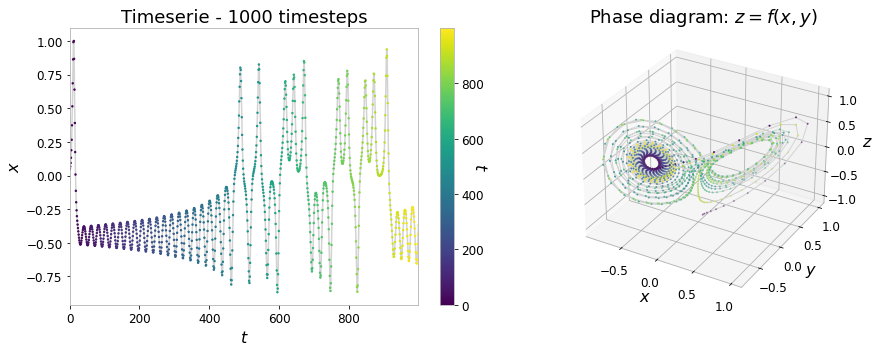

In [80]:
plot_lorenz(X, 1000)

In [81]:
units = 500
leak_rate = 0.2
spectral_radius = 1.0
input_scaling = 1.
density = 0.1
input_connectivity = 1.0
regularization = 1e-6
seed = 1234

Win = mat_gen.generate_input_weights(units, 3, input_scaling=input_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

W = mat_gen.generate_internal_weights(units, sr=spectral_radius,
                              proba=density, seed=seed)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

In [82]:
forecast = 1
(X_train, y_train), (X_test, y_test) = split_timeserie_for_task1(forecast)

states = reservoir.train([X_train], [y_train], verbose=True, return_states=True)

Training on 1 inputs (20000 steps) -- wash: 0 steps


Train: 100%|██████████| 20000/20000 [00:04<00:00, 4820.12it/s]


In [83]:
nb_generations = 500

# let's try another method here: we warm up the reservoir before generation with a previous state
# instead of using a sequence on warming inputs :
init_state = states[0][-1]
Xgen_test = X_test[: nb_generations]

Xgen, gen_states, _, _ = reservoir.generate(nb_generations, init_state=init_state)

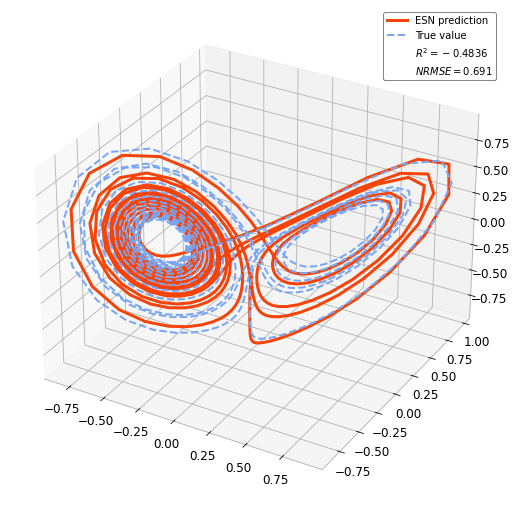

In [84]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(211, projection="3d")
plt.plot(Xgen[:, 0], Xgen[:, 1], Xgen[:, 2], lw=3, label="ESN prediction")
plt.plot(Xgen_test[:, 0], Xgen_test[:, 1], Xgen_test[:, 2], linestyle="--", lw=2, label="True value")
plt.plot([], [], ' ', label=f"$R^2 = {round(r2_score(Xgen_test, Xgen), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(Xgen_test, Xgen), 4)}$")
plt.legend(); plt.show()

Not as easy as Mackey-Glass...

More fun with ReservoirPy and chaotic data: multiscroll attractor, Rabinovich-Fabrikant equations, Hénon map...

In [85]:
from reservoirpy.datasets import multiscroll, rabinovich_fabrikant, henon_map

def plot_attractor_examples():

    Xm = multiscroll(1000)
    Xr = rabinovich_fabrikant(1000)
    Xh = henon_map(100)

    tm = np.arange(Xm.shape[0])
    tr = np.arange(Xr.shape[0])

    plt.figure(figsize=(20, 5))

    plt.subplot(131)
    plt.margins(0.05)
    plt.plot(Xm[:, 0], Xm[:, 2], color="lightgray", zorder=0)
    plt.scatter(Xm[:, 0], Xm[:, 2], cmap="viridis", c=tm, s=6)
    plt.title("Multiscroll attractor")

    plt.subplot(132)
    plt.margins(0.05)
    plt.plot(Xr[:, 0], Xr[:, 2], color="lightgray", zorder=0)
    plt.scatter(Xr[:, 0], Xr[:, 2], cmap="viridis", c=tm, s=6)
    plt.title("Rabinovich-Fabrikant system")

    plt.subplot(133)
    plt.margins(0.05)
    plt.plot(Xh[:, 0], Xh[:, 1], color="lightgray", zorder=0, lw=1)
    plt.scatter(Xh[:, 0], Xh[:, 1], cmap="viridis", c=range(len(Xh)), s=10)
    plt.title("Hénon map")

    plt.show()

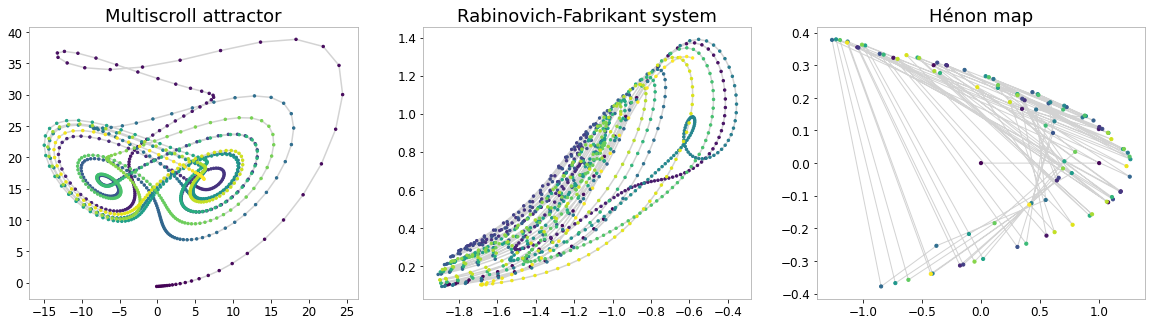

In [86]:
plot_attractor_examples()

## Now the *pièce de resistance*: real data from the real world

In [20]:
import requests
import pandas as pd

data = requests.get("https://www.data.gouv.fr/fr/datasets/r/d2671c6c-c0eb-4e12-b69a-8e8f87fc224c").json()
df = pd.DataFrame(data)
df.head()

ModuleNotFoundError: No module named 'requests'

French Covid-19 data is available at www.data.gouv.fr.

## A new task for the braves : predict the number of hospitalized people

We selected 4 interesting features: the number of people hospitalized and new hospitalizations per day, and the number of people in intensive care (*réanimation*) and new admissions in intensive care per day.

In [88]:
df = df.fillna(0)  # don't forget to remove NaN...
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date").reset_index(drop=True) # ...and to sort the data by increasing time (I forgot to do
                                                      # that the first time and it was obviously horrible)

feat_names = ['reanimation', 'hospitalises',  # hostpitalizations features names
              'nouvellesHospitalisations', 'nouvellesReanimations']  # intensive care features names

In [89]:
def plot_dataframe(features, df):
    plt.figure(figsize=(15, 5))
    for i, feat in enumerate(feat_names):
        plt.plot(df[feat], label=feat)
    ticks = [0, 50, 100, 150, 200, 250]
    plt.xticks(ticks, [df["date"].loc[i].date() for i in ticks], rotation=45)
    plt.ylabel("Reported COVID deaths")
    plt.legend(); plt.show();

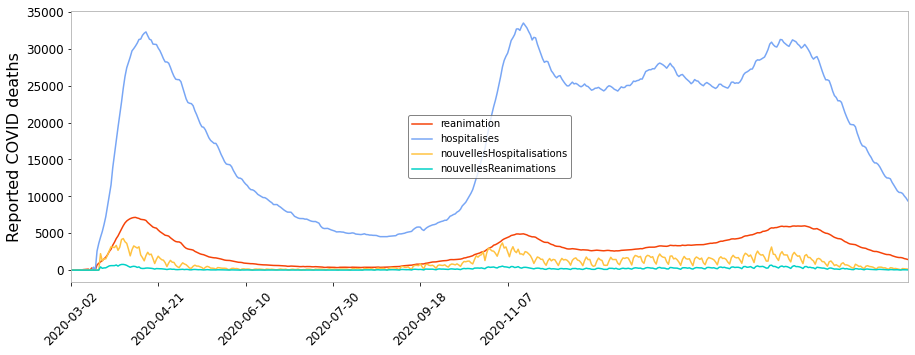

In [90]:
plot_dataframe(feat_names, df)

## Prepare the data

We apply a 5 days mean with a Hamming window on each curve, to reduce noise. We also rescale the data between 0 and 1.

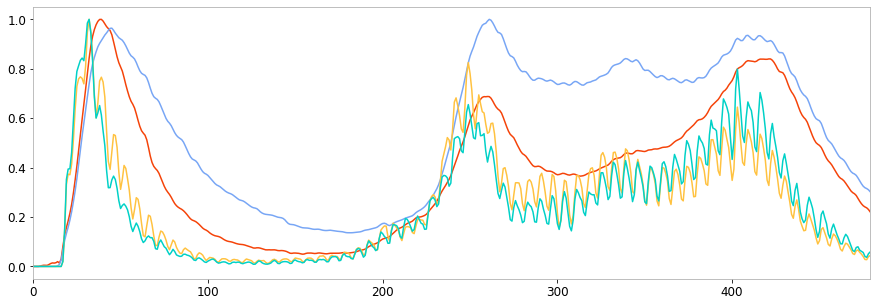

In [91]:
X_roll = np.array([df[f].rolling(5, win_type="hamming").mean().fillna(0).values for f in feat_names]).T
X = (X_roll - X_roll.min(axis=0)) / (X_roll.max(axis=0) - X_roll.min(axis=0))

plt.figure(figsize=(15, 5))
for i, feat in enumerate(feat_names):
    plt.plot(X[:, i], label=feat)

In [92]:
forecast = 1
start = 20
# 50 days forecast
train_length = len(X) - 31

x_train = X[start: train_length]
y_train = X[start+forecast: train_length+forecast]

x_test = X[train_length: -forecast]
y_test = X[train_length+forecast:]

## Train the ESN

Because we have 4 different inputs, we can decide to apply 4 different inputs scalings.

In [93]:
units = 1000
leak_rate = 0.5
spectral_radius = 0.9
inputs_scalings = [1.0, 1.0, 1.0, 1.0] # 4 input scalings, one per feature
density = 0.2
input_connectivity = 0.2
regularization = 1e-5
seed = 1234

Wins = []
bias = True
for iss in inputs_scalings:
    Win = mat_gen.generate_input_weights(units, 1, input_scaling=iss,
                                         proba=input_connectivity, input_bias=bias,
                                         seed=seed)
    bias = False  # bias added only once !
    Wins.append(Win)

Win = np.hstack(Wins)  # 4 input matrices, one per feature, merged into one


W = mat_gen.fast_spectral_initialization(units, sr=spectral_radius,
                                         proba=density, seed=seed)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

In [94]:
states = reservoir.train([x_train], [y_train], verbose=True, wash_nr_time_step=0)

y_pred, states, _, _ = reservoir.generate(x_test.shape[0], warming_inputs=x_train)

Training on 1 inputs (429 steps) -- wash: 0 steps


Train: 100%|██████████| 429/429 [00:00<00:00, 2314.56it/s]


In [95]:
def plot_covid_results():
    fig = plt.figure(figsize=(15, 5))
    color = matplotlib.rcParams['axes.prop_cycle'][:len(feat_names)]

    ax1 = fig.add_subplot(111)
    ax1.set_prop_cycle(color)
    ax1.set_title(f"{len(y_test)} days forecast of Covid hospitalization indicators")
    ax1.plot(y_pred)
    ax1.plot(y_test, linestyle="--")
    ax1.plot([],[], color="black", label="Generated")
    ax1.plot([],[], linestyle="--", color="black", label="Real")
    ax1.plot([],[],' ', label=f"$R^2={round(r2_score(y_test, y_pred), 4)}$")
    ax1.plot([],[],' ', label=f"$NRMSE={round(nrmse(y_test, y_pred), 4)}$")
    ax1.set_ylabel("Normalized indicator")
    ticks = [i for i in range(0, len(y_test), 5)]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels([df["date"].loc[len(y_train) + i].date() for i in ticks], rotation=45)
    ax1.legend()

    plt.show()

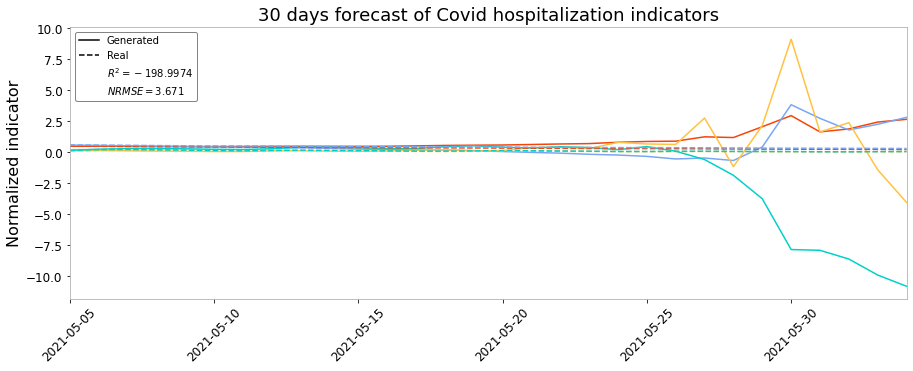

In [96]:
plot_covid_results()

## What you could try then:

- Playing with the parameters
- Some feature engineering and "old school" data science
- Hyperopt and ReservoirPy hyperoptimization tools
- Add some feedback
- Try ensembling methods with several estimators
- Contact French government when you are done (and save the world)